In [21]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import h5py
from torch.utils.data import DataLoader
import os

This function will collect the paths for all of the images and masks. We will later use these paths to load the image on demand. This is much better than holding all of them in memory. I tried loading 5000 images in memory at once and it needed more than 16GB RAM.

In [1]:
def collect_sample_paths(top_dir, max_frames_per_subset=None):
    sample_paths = []

    for subset_folder in os.listdir(top_dir):
        outer_path = os.path.join(top_dir, subset_folder)
        nested_path = outer_path
        images_path = os.path.join(nested_path, 'images')
        if not os.path.isdir(images_path):
            print(f"[!] Skipping: {images_path} not found.")
            continue

        for cam_folder in os.listdir(images_path):
            if not cam_folder.endswith("_final_hdf5"):
                continue

            final_path = os.path.join(images_path, cam_folder)
            geom_path = os.path.join(images_path, cam_folder.replace("_final_hdf5", "_geometry_hdf5"))

            if not os.path.isdir(final_path) or not os.path.isdir(geom_path):
                continue

            print(f"📂 Processing {subset_folder}/{cam_folder}...")
            color_files = sorted([f for f in os.listdir(final_path) if f.endswith(".color.hdf5")])
            print(f"  → Found {len(color_files)} .color.hdf5 files")

            selected_files = color_files if max_frames_per_subset is None else color_files[:max_frames_per_subset]

            valid_pairs = 0
            for fname in selected_files:
                frame_id = fname.replace(".color.hdf5", "")
                color_fp = os.path.join(final_path, fname)
                semantic_fp = os.path.join(geom_path, f"{frame_id}.semantic.hdf5")

                if os.path.exists(semantic_fp):
                    sample_paths.append((color_fp, semantic_fp))
                    valid_pairs += 1

            print(f"  ✅ Matched {valid_pairs} image-mask pairs")

    print(f"\n📦 Total matched samples: {len(sample_paths)}")
    return sample_paths


In [4]:
class HypersimSegmentationDataset(Dataset):
    def __init__(self, sample_paths, transform=None, target_transform=None):
        self.sample_paths = sample_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sample_paths)
    
    def __getitem__(self, idx):
        color_path, semantic_path = self.sample_paths[idx]

        with h5py.File(color_path, 'r') as f_color:
            rgb = np.array(f_color['dataset'])  # shape (H, W, 3)

        with h5py.File(semantic_path, 'r') as f_sem:
            mask = np.array(f_sem['dataset'])  # shape (H, W)

        # Normalize RGB from [0, 1] float → uint8 image
        rgb_disp = (np.clip(rgb / np.percentile(rgb, 99), 0, 1) * 255).astype(np.uint8)

        if self.transform:
            rgb_disp = self.transform(rgb_disp)
        if self.target_transform:
            mask = self.target_transform(mask)

        return rgb_disp, mask


In [5]:
base_dir = r"G:\Volumes\portable_hard_drive\evermotion_dataset\scenes"
sample_paths = collect_sample_paths(base_dir)


📂 Processing ai_001_001/scene_cam_00_final_hdf5...
  → Found 98 .color.hdf5 files
  ✅ Matched 98 image-mask pairs
📂 Processing ai_001_002/scene_cam_00_final_hdf5...
  → Found 99 .color.hdf5 files
  ✅ Matched 99 image-mask pairs
📂 Processing ai_001_002/scene_cam_01_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_002/scene_cam_02_final_hdf5...
  → Found 98 .color.hdf5 files
  ✅ Matched 98 image-mask pairs
📂 Processing ai_001_002/scene_cam_03_final_hdf5...
  → Found 96 .color.hdf5 files
  ✅ Matched 96 image-mask pairs
📂 Processing ai_001_003/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_004/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_005/scene_cam_00_final_hdf5...
  → Found 100 .color.hdf5 files
  ✅ Matched 100 image-mask pairs
📂 Processing ai_001_005/scene_cam_01_final_hdf5...
  → Found 100 .color.hdf5 fil

In [22]:
dataset = HypersimSegmentationDataset(sample_paths)

In [16]:
len(dataset)

5715

In [11]:
# here we call our dataset and it will read the files and return the image and the mask.
rgb_img, mask = dataset[1]

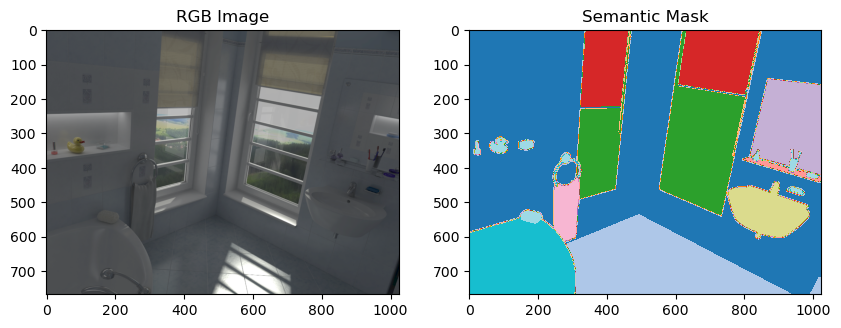

In [19]:
norm_factor = np.percentile(rgb_img, 99)  # images need to be normalized because they come from hdf5 format
rgb_norm = rgb_img / norm_factor
gamma = 2.2 # Gamma correction is needed to make the image brighter
rgb_corrected = np.power(rgb_img / norm_factor, 1 / gamma)
rgb_disp = (np.clip(rgb_corrected, 0, 1) * 255).astype(np.uint8)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_disp)
plt.title("RGB Image")

plt.subplot(1, 2, 2)
plt.imshow(mask.astype(np.int32), cmap='tab20')
plt.title("Semantic Mask")
plt.show()

In [23]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)